# Sentiment analysis of written text
Author: Camilo

## Data set
We load the EmoBank data set

https://github.com/JULIELab/EmoBank

Sven Buechel and Udo Hahn. 2017. EmoBank: Studying the Impact of Annotation Perspective and Representation Format on Dimensional Emotion Analysis. In EACL 2017 - Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics. Valencia, Spain, April 3-7, 2017. Volume 2, Short Papers, pages 578-585. Available: http://aclweb.org/anthology/E17-2092

Sven Buechel and Udo Hahn. 2017. Readers vs. writers vs. texts: Coping with different perspectives of text understanding in emotion annotation. In LAW 2017 - Proceedings of the 11th Linguistic Annotation Workshop @ EACL 2017. Valencia, Spain, April 3, 2017, pages 1-12. Available: https://sigann.github.io/LAW-XI-2017/papers/LAW01.pdf

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [35]:
eb = pd.read_csv("C:\\Users\\fast\\camilo\\ST7\\EmoBank-master\\corpus\\emobank.csv")
pd.set_option('max_colwidth', 120)
eb = eb.drop(['id'], axis=1)
eb.head()

,split,V,A,D,text
0,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,test,2.80,3.10,2.80,If I wasn't working here.
2,train,3.00,3.00,3.00,".."""
3,train,3.44,3.00,3.22,Goodwill helps people get off of public assistance.
4,train,3.55,3.27,3.46,Sherry learned through our Future Works class that she could rise out of the mire of the welfare system and support ...


### Some data exploration

Histograms of Valence, Arousal and Dominance respectively


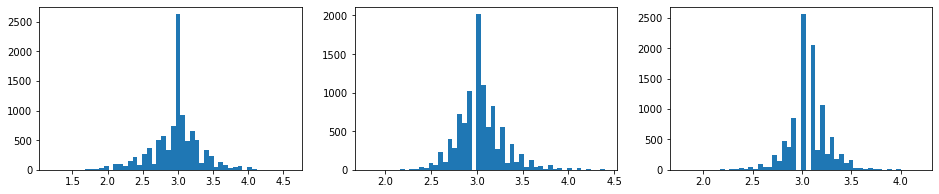

In [3]:
##### import matplotlib.pyplot as plt

print('Histograms of Valence, Arousal and Dominance respectively')
valence, arousal, dominance = eb['V'], eb['A'], eb['D']
VAR = [valence, arousal, dominance]
fig, axes = plt.subplots(1,3,figsize=(16,3))
for i, ax in enumerate(axes.flat):
    ax.hist(VAR[i], bins=50) 

## NRC VAD lexicon

Using lexicons from Saif M. Mohammad: http://www.saifmohammad.com/WebPages/lexicons.html

And pre-trained word embedding vectors: https://nlp.stanford.edu/projects/glove/

Obtaining Reliable Human Ratings of Valence, Arousal, and Dominance for 20,000 English Words. Saif M. Mohammad. In Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics, Melbourne, Australia, July 2018.

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

In [4]:
VAD_words = pd.read_csv("NRC-VAD_glove-wiki-gigaword-300.csv", index_col=0)
VAD_words.head()

,valence,arousal,dominance,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299,dim_300
word,,,,,,,,,,,,,,,,,,,,,
aardvark,0.427,0.490,0.437,-0.349260,-0.553240,-0.430850,0.510470,0.40767,0.095694,-0.17689,...,-0.500660,-0.157680,-0.77059,0.005665,-0.321810,-0.78144,0.164200,0.624030,0.17806,-0.101510
aback,0.385,0.407,0.288,0.018572,-0.091755,0.234470,-0.398870,0.14438,0.041793,0.45685,...,0.136600,-0.410070,0.34458,-0.069210,-0.011236,-0.28098,0.070116,0.403770,-0.14337,0.065997
abacus,0.510,0.276,0.485,-0.002865,-0.071534,-0.346530,0.275440,0.19806,-0.097807,-0.13528,...,-0.312060,-0.161740,-0.54930,0.276720,0.714070,-0.35514,-0.180200,0.405210,-0.24642,0.005458
abalone,0.500,0.480,0.412,0.709240,0.460650,-0.038441,0.039853,-0.00113,0.030408,-0.44903,...,-0.057243,0.016303,0.74038,0.018888,-0.468430,-0.53066,0.449360,0.037575,0.95823,-0.346630
abandon,0.052,0.519,0.245,0.255620,-0.166040,-0.120690,-0.432870,0.10721,-0.493020,0.36993,...,-0.588510,-0.490100,0.48357,-0.027909,-0.023546,0.18434,0.061770,-0.258670,0.14337,0.014162


Histograms of Valence, Arousal and Dominance respectively, word level


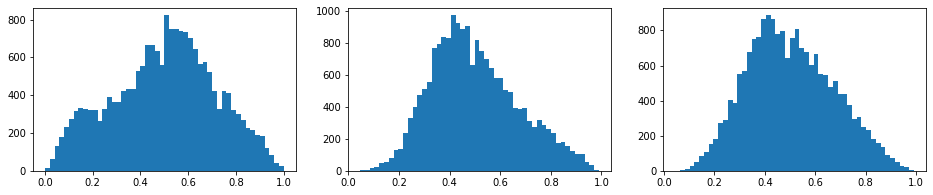

In [5]:
print('Histograms of Valence, Arousal and Dominance respectively, word level')
VAR_w = [VAD_words['valence'], VAD_words['arousal'], VAD_words['dominance']]
fig, axes = plt.subplots(1,3,figsize=(16,3))
for i, ax in enumerate(axes.flat):
    ax.hist(VAR_w[i], bins=50) 

## Let's try different approaches!
Goal is to predict the VAD values of a sentence from its input. Then it would also be great to acquire some model understanding on the way!
### Approach 1 : average of word's VAD value
An intuitive way of facing this problem could be to just take the mean of the VAD values for each word in the sentence. That way, if we had more negative words (valence) the sentence would naturally be more negative. The parameters to learn in this case would be those of the simple linear relation:
$$VADsentence(x_1, x_2, \dots x_n) = a*(VADword(x_1)+VADword(x_2)+ \dots +VADword(x_n))/n+b$$
Notice that they are all 3 component vectors.

In [86]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x)
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    a = SS_xy / SS_xx 
    b = m_y - a*m_x 
  
    return(a, b)

In [7]:
import re
def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def get_vec(word):
    #returns vad+300 glove vector
    return VAD_words.loc[word]

In [9]:
get_vec('letter')

valence      0.635000
arousal      0.279000
dominance    0.342000
dim_1       -0.362010
dim_2       -0.429600
               ...   
dim_296      0.068602
dim_297      0.623580
dim_298     -0.595160
dim_299     -0.433940
dim_300     -0.431170
Name: letter, Length: 303, dtype: float64

In [10]:
def compute_VAD_mean(sentence):
    #takes a string (sentence) and returns the average VAD vector
    sentence = sentence.lower()
    sentence = normalizeString(sentence)
    words = sentence.split()
    vectors = []
    for word in words:
        try:
            vec = [i for i in VAD_words.loc[word][:3]]
            vectors.append(vec)
        except:
            #if word not in the lexicon then it must be neutral
            vectors.append([.5, .5, .5])
    valence = np.mean([vector[0] for vector in vectors])
    arrousal = np.mean([vector[1] for vector in vectors])
    dominance = np.mean([vector[2] for vector in vectors])
    return valence, arrousal, dominance

In [11]:
compute_VAD_mean('.."')

(0.5, 0.5, 0.5)

We add columns to keep the VAD average values

In [36]:
eb["V_words"] = ""
eb["A_words"] = ""
eb["D_words"] = ""

In [39]:
for i in range(len(eb)):
    eb['V_words'][i], eb['A_words'][i], eb['D_words'][i] = compute_VAD_mean(eb['text'][i])

In [40]:
eb.head()

,split,V,A,D,text,V_words,A_words,D_words
0,train,3.00,3.00,3.20,"Remember what she said in my last letter? """,0.545667,0.466778,0.477333
1,test,2.80,3.10,2.80,If I wasn't working here.,0.534286,0.512143,0.510857
2,train,3.00,3.00,3.00,"..""",0.5,0.5,0.5
3,train,3.44,3.00,3.22,Goodwill helps people get off of public assistance.,0.614444,0.483333,0.570111
4,train,3.55,3.27,3.46,Sherry learned through our Future Works class that she could rise out of the mire of the welfare system and support ...,0.596875,0.474125,0.549542


Now we only consider the training sentences

In [41]:
train_1 = eb[eb.split=='train']

### Estimating coefficients for valence

In [87]:
a_val, b_val = estimate_coef(train_1['V_words'], train_1['V'])
print('Coefficients for Valence: a = '+str(a_val)+', b = '+str(b_val))

Coefficients for Valence: a = 2.839421168278393, b = 1.454510105282507


### Testing the approach
We will now consider the test set, we'll predict the valence of the text and we'll compare it with the actual value

In [60]:
test_1 = eb[eb.split=='test']
prediction_1_val = []
for i in test_1['V_words']:
    prediction_1_val.append(a_val*i + b_val)

In [66]:
MSE_Val = ((prediction_1_val - test_1['V'].values)**2).mean()
print('Mean squared error of approach 1 for valence = '+str(MSE_Val))

Mean squared error of approach 1 for valence = 0.099985207718358


Lets look at a couple of examples to see if it isn't a generalisation...

In [77]:
for i in [7518, 4949, 7066, 2947]:
    print('--------------------------------------------------------------------------------------')
    val_word = test_1['V_words'][i]
    val, pred = test_1['V'][i], val_word*a_val + b_val
    print(test_1['text'][i])
    print('Valence = {}, predicted valence = {}'.format(val,pred))

--------------------------------------------------------------------------------------
When my father died, a year after my mother, my sisters and I cleaned out their apartment.
Valence = 2.0, predicted valence = 2.9570371401631563
--------------------------------------------------------------------------------------
Outdated baby food found on shelves
Valence = 1.89, predicted valence = 3.217317413922009
--------------------------------------------------------------------------------------
So empty it hurt.
Valence = 2.0, predicted valence = 2.4483075141799446
--------------------------------------------------------------------------------------
"This is a criminal act and it certainly puts things in a different league,"
Valence = 2.0, predicted valence = 2.852316583266413


In [84]:
for i in [4455, 4618, 3871, 2613]:
    print('--------------------------------------------------------------------------------------')
    val_word = test_1['V_words'][i]
    val, pred = test_1['V'][i], val_word*a_val + b_val
    print(test_1['text'][i])
    print('Valence = {}, predicted valence = {}'.format(val,pred))

--------------------------------------------------------------------------------------
And the last lesson -- have fun .
Valence = 4.0, predicted valence = 3.2307708618383764
--------------------------------------------------------------------------------------
Canadian breakthrough offers hope on autism
Valence = 3.88, predicted valence = 3.036067696013572
--------------------------------------------------------------------------------------
We slammed against the doorway and I was laughing too, the pulse close enough to shake the doorframe and set up vibrations in my chest, Rachel in my arms because she’d used me to soften her landing.
Valence = 4.1, predicted valence = 2.8976641154777454
--------------------------------------------------------------------------------------
The proverbial hospitality and warm welcome are still here.
Valence = 3.75, predicted valence = 3.188260670633294


Finally, for arrousal and dominance we have the following errors

In [91]:
a_arr, b_arr = estimate_coef(train_1['A_words'], train_1['A'])
a_dom, b_dom = estimate_coef(train_1['D_words'], train_1['D'])
prediction_1_arr, prediction_1_dom = [], []
for i in test_1['A_words']:
    prediction_1_arr.append(a_arr*i + b_arr)
for i in test_1['D_words']:
    prediction_1_dom.append(a_dom*i + b_dom)
MSE_Arr = ((prediction_1_arr - test_1['A'].values)**2).mean()
print('Mean squared error of approach 1 for valence = '+str(MSE_Arr))
MSE_Dom = ((prediction_1_dom - test_1['D'].values)**2).mean()
print('Mean squared error of approach 1 for valence = '+str(MSE_Dom))

Mean squared error of approach 1 for valence = 0.05831941043231876
Mean squared error of approach 1 for valence = 0.0436326241882095
